In [1]:
import CSV
using DataFrames: DataFrame
using StatsBase: mean
using Dates
using Plots

include("../src/model.jl")
include("../src/inference/involutive_mcmc.jl")

subtree_involution (generic function with 1 method)

In [2]:
data = CSV.File("../data/tsdl.161.csv"; header=[:ds, :y], types=Dict(:ds=>Dates.Date, :y=>Float64));
df = DataFrame(data)

Row,ds,y
,Date,Float64
1,1949-01-01,112.0
2,1949-02-01,118.0
3,1949-03-01,132.0
4,1949-04-01,129.0
5,1949-05-01,121.0
6,1949-06-01,135.0
7,1949-07-01,148.0
8,1949-08-01,148.0
9,1949-09-01,136.0


In [3]:
# Normalize and scale the data in the DataFrame
# Convert dates to numeric (days since first date)
df.xs = Float64.([(d - df.ds[1]).value for d in df.ds])
df.ys = collect(df[!, :y])

# Normalize xs to [0, 1] range
df.xs = df.xs .- minimum(df.xs)
df.xs = df.xs ./ maximum(df.xs)

# Center ys to mean 0 and scale to fit in [-2, 2]
df.ys = df.ys .- mean(df.ys)
df.ys = df.ys .* (4 / (maximum(df.ys) - minimum(df.ys)))

xs = df.xs
ys = df.ys


144-element Vector{Float64}:
 -1.2996031746031744
 -1.2532711282711282
 -1.14516302016302
 -1.1683290433290432
 -1.2301051051051048
 -1.1219969969969967
 -1.0216108966108965
 -1.0216108966108965
 -1.114274989274989
 -1.2455491205491205
 -1.3613792363792363
 -1.2532711282711282
 -1.2764371514371513
  ⋮
  1.0556091806091807
  0.85483697983698
  1.0710531960531964
  1.3953775203775205
  1.4803196053196055
  1.9668060918060921
  2.638620763620764
  2.51506864006864
  1.7583118833118836
  1.3953775203775205
  0.8471149721149723
  1.1714392964392966

In [4]:
include("../src/inference/particle_filter.jl")

traces = gp_particle_filter(xs, ys, 5, 5, 5, 25);

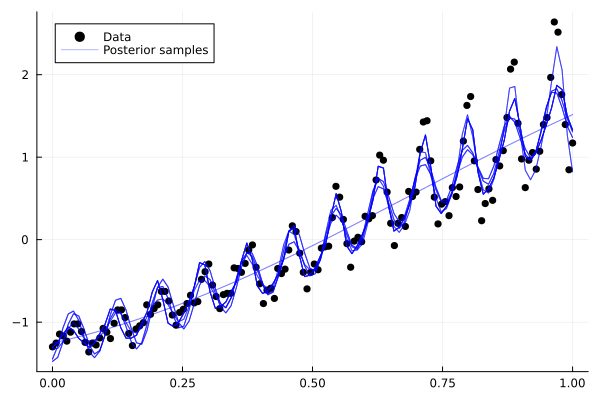

In [5]:
include("../src/covariance.jl")


function plot_posterior_samples(traces, xs, ys)
    p = scatter(xs, ys, label="Data", color=:black, markersize=4)
    
    x_test = collect(range(minimum(xs), maximum(xs), length=100))
    
    # Plot each posterior sample
    for (i, tr) in enumerate(traces)
        kernel = get_retval(tr)
        noise = tr[:noise]
        
        # Posterior predictive mean
        μ, σ² = compute_predictive(kernel, noise, xs, ys, x_test)
        
        plot!(p, x_test, μ, alpha=0.3, label=(i==1 ? "Posterior samples" : ""), 
              color=:blue)
    end
    
    return p
end

plot_posterior_samples(traces, xs, ys)